<a href="https://colab.research.google.com/github/nyoons/ESAA/blob/main/2022_11_28_%EA%B3%BC%EC%A0%9C_%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>**06. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷**

**규제 선형 모델의 개요**

회귀 모델은 적절히 데이터에 적합하며 회귀 계수가 커지는 것은 제어해야함. RSS 최소화만 고려하면 문제가 많이 생김. 예측 성능 저하됨. 균형을 이루어야함. 알파 값 증가 : 회귀 계수 w 감소 / 알파 값 감소 : RSS 최소화. 비용 함수에 알파 값으로 페널티 부여해 회귀 계수 값의 크기를 감소시키는 것이 규제. **L2 규제**가 W의 제곱에 대해 페널티를 부여하는 방식. -> **릿지**. **L1 규제**는 W의 절댓값에 대해 페널티 부여하는 방식 -> **라쏘**. 

**릿지 회귀**

사이킷런의 Ridge 클래스 이용. 주요 생성 파라미터는 alpha =  릿지 회귀의 alpha L2 규제 계수.

In [1]:
#보스턴 회귀 한 거 불러오기
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

#데이터 세트 로드
boston=load_boston()

#보스턴 데이터 세트 DF 변환
bostonDF=pd.DataFrame(boston.data, columns=boston.feature_names)

#boston 데이터 세트의 target 배열은 주택 가격. 이를 price 칼럼으로 DF에 추가.
bostonDF['PRICE']=boston.target
print('boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_data, y_target, test_size=0.3, random_state=156)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

boston 데이터 세트 크기: (506, 14)


In [2]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

#alpha=10으로 릿지 회귀 수행
ridge=Ridge(alpha=10)
neg_mse_scores=cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

print('5 folds의 개별 negative mse scores:', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds의 개별 negative mse scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE : 5.518


이전 예제의 규제 없는 linearregression의 rmse 평균보다 뛰어남.

릿지의 alpha 값을 0, 0.1, 1, 10, 100으로 변화시키며 RMSE와 회귀 계수 값 변화를 살펴보자. alpha 값이 커지면 회귀 계수 값을 작게 만든다는 것 기억.

In [3]:
#릿지에 사용될 alpha 파라미터 값을 정의
alphas=[0, 0.1, 1, 10, 100]

#alphas list 값을 반복하며 alpha에 따른 평균 rmse를 구함.
for alpha in alphas:
  ridge=Ridge(alpha=alpha)

  #cross_val_score를 이용해 5폴드의 평균 rmse 계산
  neg_mse_scores=cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
  avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
  print('alpha {0} 일 때 5folds의 평균 rmse: {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5folds의 평균 rmse: 5.829
alpha 0.1 일 때 5folds의 평균 rmse: 5.788
alpha 1 일 때 5folds의 평균 rmse: 5.653
alpha 10 일 때 5folds의 평균 rmse: 5.518
alpha 100 일 때 5folds의 평균 rmse: 5.330


100일 때 가장 좋다.

alpha 값 변화에 따른 피처의 회귀 계수 값을 시각화해보자.

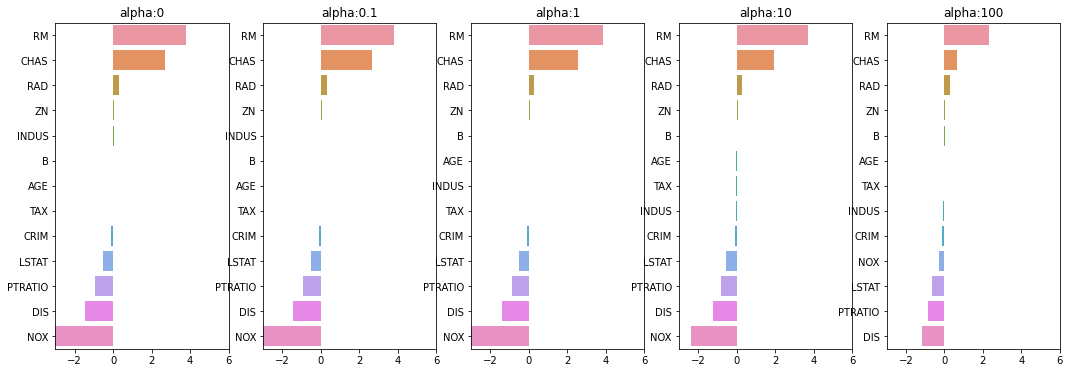

In [4]:
#각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs=plt.subplots(figsize=(18,6), nrows=1, ncols=5)
#각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DF 생성
coeff_df=pd.DataFrame()

#alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치를 지정해줌.
for pos, alpha in enumerate(alphas):
  ridge=Ridge(alpha=alpha)
  ridge.fit(X_data, y_target)
  #alpha에 따른 피처별로 회귀 계수를 series로 변환하고 이를 DF에 칼럼으로 추가
  coeff=pd.Series(data=ridge.coef_, index=X_data.columns)
  colname='alpha:'+str(alpha)
  coeff_df[colname]=coeff
  #막대 그래프로 각 알파 값에서의 회귀 계수 시각화, 회귀 계수값이 높은 순으로 표현
  coeff=coeff.sort_values(ascending=False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3, 6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

#for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 Df로 표시
plt.show()

역시 알파 값 증가 -> 회귀 계수 값 작아짐. 릿지 회귀 계수 값을 구해보자.

In [5]:
ridge_alphas=[0, 0.1, 1, 10, 100]
sort_column='alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


역시 알파 커질수록 회귀 계수 작아짐. 하지만 릿지 회귀는 계수를 0으로 만들지는 않는다.

**라쏘 회귀**

L2 규제는 회귀 계수를 감소시키는데 반해, L1 규제는 불필요한 계수를 0으로 만들어버림. 적절한 피처만 회귀에 포함시키는 특성을 가짐.

Lasso 클래스. 마찬가지로 alpha 파라미터를 갖고 라쏘 회귀의 alpha L1 규제 계수에 해당.

In [6]:
from sklearn.linear_model import Lasso, ElasticNet

#alpha 값에 따른 회귀 모델의 폴드 평균  RMSE 출력하고 회귀 계수값들을 DF으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
  coeff_df=pd.DataFrame()
  if verbose : print('#####', model_name, '#####')
  for param in params:
    if model_name=='Ridge':model=Ridge(alpha=param)
    elif model_name=='ElasticNet':model=ElasticNet(alpha=param, l1_ratio=0.7)
    elif model_name=='Lasso':model=Lasso(alpha=param)
    neg_mse_scores=cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
    avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 rmse: {1:.3f}'.format(param, avg_rmse))
    #cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
    model.fit(X_data, y_target)
    #alpha에 따른 피처별 회귀 계수를 series로 변환하고 이를 DF의 칼럼으로 추가
    coeff=pd.Series(data=model.coef_, index=X_data.columns)
    colname='alpha:'+str(param)
    coeff_df[colname]=coeff
  return coeff_df

#end of get_linear_regre_eval

함수 생성했으면 이를 이용해 알파값의 변화에 따른 rmse와 회귀계수들 출력.

In [7]:
#라쏘에 사용될 alpha 파라미터 값 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas=[0.07, 0.1, 0.5, 1,3]
coeff_lasso_df=get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

##### Lasso #####
alpha 0.07일 때 5 폴드 세트의 평균 rmse: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 rmse: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 rmse: 5.669
alpha 1일 때 5 폴드 세트의 평균 rmse: 5.776
alpha 3일 때 5 폴드 세트의 평균 rmse: 6.189


0.07에서 가장 좋은 평균 rmse. 릿지보단 약간 떨어지지만 그냥 linearregression보단 낫다. 회귀 계수도 보자.

In [8]:
#반환된 coeff_lasso_df를 첫번째 칼럼순으로 내림차순 정렬해 회귀계수 Df출력
sort_column='alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


일부는 아예 0으로 바뀜. 피처 선택의 효과.

**엘라스틱넷 회귀**

L2 규제와 L1 규제를 합침. 라쏘 회귀가 서로 상관관계 높은 피처들의 경우 이들 중에 중요 피처만을 셀렉하고 다른 피처들 계수를 0으로 만드는 성향 강함. 엘라스틱넷 회귀는 이를 완화하기 위해 L2 규제 추가. 시간이 단점.

ElasticNet 클래스. 주요 생성 파라미터는 alpha와 l1_rato. 여기서 알파 값은 앞과 다름. a*L1+b*L2에서 a+b 값. l1_ratio는 a/(a+b) 값. 

alpha 값을 변화시키며 rmse와 각 피처의 회귀 계수 출력하자.

In [9]:
#엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
#l1_ratio는 0.7 고정
elastic_alphas=[0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df=get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

##### ElasticNet #####
alpha 0.07일 때 5 폴드 세트의 평균 rmse: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 rmse: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 rmse: 5.467
alpha 1일 때 5 폴드 세트의 평균 rmse: 5.597
alpha 3일 때 5 폴드 세트의 평균 rmse: 6.068


In [10]:
#반환된 coeff_elastic_df를 첫번째 칼럼순으로 내림차순 정렬해 회귀계수 DF 출력
sort_column='alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


라쏘보단 0되는 값이 적다.

어떤 것이 가장 좋은지는 상황에 따라 다름. 최적의 예측 성능 찾아야함.

**선형 회귀 모델을 위한 데이터 변환**

선형 회귀 모델은 피처와 타깃 값의 분포가 정규분포인 것을 선호. 데이터에 대한 스케일링/정규화 작업 수행이 일반적.

1. standardScaler 클래스 이용해 평균이 0, 분산이 1인 표준 정규 분포 데이터 세트로 변환하거나 minmaxscaler 클래스 이용해 최솟값 0, 최대값 1인 값으로 정규화
2. 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용해 변환
3. 원래 값에 log 함수 적용. **로그 변환**. 많이 사용됨.

보스턴 주택가격 피처 데이터 세트에 위의 세가지 변환 적용해 rmse로 각 경우별 예측 성능 측정해보자. p_degree는 다항식 특성 추가 시 다항식 차수 입력됨.

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

In [14]:
#method는 표준 정규 분포 변환, 최댓값/최솟값 정규화, 로그변환 결정
#p_degree는 다항식 특성을 추가할 때 적용. 2이상 부여하지 않음.
def get_scaled_data(method='None', p_degree=None, input_data=None):
  if method=='Standard':
    scaled_data=StandardScaler().fit_transform(input_data)
  elif method=='MinMax':
    scaled_data=MinMaxScaler().fit_transform(input_data)
  elif method=='Log':
    scaled_data=np.log1p(input_data)
  else:
    scaled_data=input_data

  if p_degree !=None:
    scaled_data=PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
  return scaled_data

ridge 클래스의 알파 값 변화시키며 피처 데이터 세트를 여러 방법으로 변환한 데이터 세트를 입력받을 때 rmse 값이 어떻게 변하는지 살펴보자.

In [15]:
#Ridge의 알파 값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출.
alphas=[0.1, 1, 10, 100]

#5개 방식으로 변환. 먼저 원본 그대로, 표준정규 분포, 표준정규 분포+다항식 특성
#최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
  X_data_scaled=get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
  print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
  get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 rmse: 5.788
alpha 1일 때 5 폴드 세트의 평균 rmse: 5.653
alpha 10일 때 5 폴드 세트의 평균 rmse: 5.518
alpha 100일 때 5 폴드 세트의 평균 rmse: 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 rmse: 5.826
alpha 1일 때 5 폴드 세트의 평균 rmse: 5.803
alpha 10일 때 5 폴드 세트의 평균 rmse: 5.637
alpha 100일 때 5 폴드 세트의 평균 rmse: 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 rmse: 8.827
alpha 1일 때 5 폴드 세트의 평균 rmse: 6.871
alpha 10일 때 5 폴드 세트의 평균 rmse: 5.485
alpha 100일 때 5 폴드 세트의 평균 rmse: 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 rmse: 5.764
alpha 1일 때 5 폴드 세트의 평균 rmse: 5.465
alpha 10일 때 5 폴드 세트의 평균 rmse: 5.754
alpha 100일 때 5 폴드 세트의 평균 rmse: 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 rmse: 5.298
alpha 1일 때 5 폴드 세트의 평균 rmse: 4.323
alpha 10일 때 5 폴드 세트의 평균 rmse: 5.185
alpha 100일 때 5 폴드 세트의 평균 rmse: 6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 rmse: 4.770

표준정규와 최소최대는 개선 없음. 한계도 있음. 로그 변환이 확실한 효과.

>**07. 로지스틱 회귀**

선형 회귀 방식을 분류에 적용. 로지스틱 회귀가 선형과 다른 점은 학습을 통해 선형 함수의 최적선을 찾는게 아니라 시그모이드 함수(S자 모양, 항상 0과 1 사이 값을 반환) 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 분류 결정.

위스콘신 유방암 데이터 세트를 이용해 로지스틱 회귀로 암 여부 판단.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer=load_breast_cancer()

로지스틱 회귀는 정규 분포도에 따라 예측 성능 영향을 받을 수 있으므로 데이터에 먼저 정규 분포 형태의 표준 스케일링 적용하고 데이터 세트 분리할 것.

In [17]:
from sklearn.model_selection import train_test_split

#StandardScaler()로 평균 0, 분산 1로 데이터 분포 변환
scaler=StandardScaler()
data_scaled=scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test=train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score

#로지스틱 회귀를 이용해 학습 및 예측 수행
lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds=lr_clf.predict(X_test)

#정확도와 roc_auc 측정
print('accuracy: {0:.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc: {0:.3f}'.format(roc_auc_score(y_test, lr_preds)))

accuracy: 0.977
roc_auc: 0.972


사이킷런 로지스틱회귀 클래스의 주요 하이퍼 파라미터로 penalty(규제 유형 설정, 기본은 l2)와 c(규제 강도를 조절하는 alpha값의 역수, 작을수록 규제 큼)가 있음.

In [19]:
from sklearn.model_selection import GridSearchCV

params={'penalty':['12', 'l1'], 'C':[0.01, 0.1, 1, 1, 5, 10]}

grid_clf=GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
36 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    % (all_penalties, penalty)
ValueError:

ValueError: ignored

로지스틱 장점 많음.

>**08. 회귀 트리**

머신러닝 기반의 회귀는 회귀 계수를 기반으로 하는 최적의 회귀 함수를 도출하는 것이 주요 목표. 이 절에선 회귀 함수를 기반으로 하지 않고 결정 트리와 같이 트리를 기반으로 하는 회귀 방식을 소개. 회귀를 위한 트리를 생성하고 이를 기반으로 회귀 예측. 리프 노드에서 예측 결정 값을 만드는 과정이 다름. 분류 트리가 특정 클래스 레이블을 결정하는 것과 달리, 회귀 트리는 리프 노드에 속한 데이터 값의 평균을 구해 회귀 예측값을 계산.

어떻게 동작하는지 살펴보자. 2차원 데이터. X 피처를 결정 트리 기반으로 분할. 규칙 노드로 분할. 트리 분할 완료되면 리프 노드에 소속된 데이터 값의 평균을 구해 최종적으로 리프노드에 결정 값으로 할당. 앞에서 소개한 결정 트리, 랜덤 포레스트, GBM, XGBoost, LGBM 등 모든 트리 기반 알고리즘은 회귀도 가능.

랜덤 포레스트 회귀 트리인 RandomForestRegressor 이용해 보스턴 주택 가격 예측 수행하자.

In [20]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

#보스턴 데이터 세트 로드
boston=load_boston()
bostonDF=pd.DataFrame(boston.data, columns=boston.feature_names)

bostonDF['PRICE']=boston.target
y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)

rf=RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores=cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

print('5 교차 검증의 개별 negative mse scores:', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 rmse scores:', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 rmse: {0:.3f}'.format(avg_rmse))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

5 교차 검증의 개별 negative mse scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 rmse scores: [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 rmse: 4.423


결정 트리, GBM, XGB, LGBM의 회귀를 모두 이용해 예측해보자.

In [25]:
def get_model_cv_predcition(model, X_data, y_target):
  neg_mse_scores=cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
  rmse_scores=np.sqrt(-1*neg_mse_scores)
  avg_rmse=np.mean(rmse_scores)
  print('#####', model.__class__.__name__, '#####')
  print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg=DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg=RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg=GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg=XGBRegressor(n_estimators=1000)
lgb_reg=LGBMRegressor(n_estimators=1000)

#트리 기반의 회귀 모델 반복하며 평가 수행
models=[dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
  get_model_cv_predcition(model, X_data, y_target)

##### DecisionTreeRegressor #####
5 교차 검증의 평균 RMSE : 5.978
##### RandomForestRegressor #####
5 교차 검증의 평균 RMSE : 4.423
##### GradientBoostingRegressor #####
5 교차 검증의 평균 RMSE : 4.269
[13:18:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:18:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
##### XGBRegressor #####
5 교차 검증의 평균 RMSE : 4.089
##### LGBMRegressor #####
5 교차 검증의 평균 RMSE : 4.646


회귀 트리는 회귀 계수를 제공하는 coef_ 속성이 없다. 대신 피처별 중요도는 알 수 있음.

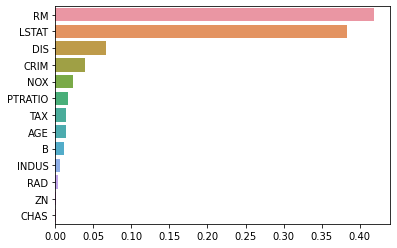

In [27]:
import seaborn as sns 
%matplotlib inline

rf_reg=RandomForestRegressor(n_estimators=1000)

#앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습합니다.
rf_reg.fit(X_data, y_target)

feature_series=pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series=feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

회귀 트리 regressor가 어떻게 예측값을 판단하는지 선형 회귀와 비교해 시각화하자. 결정 트리의 max_depth 변화시키며 회귀 트리 예측선 변화 살펴보자. 1개의 변수만 추출하자.

(100, 2)


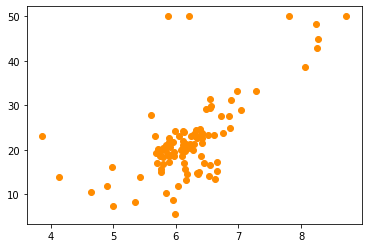

In [28]:
bostonDF_sample=bostonDF[['RM', 'PRICE']]
bostonDF_sample=bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')

In [30]:
#max_depth 변화해서 보면?
import numpy as np
from sklearn.linear_model import LinearRegression

#선형 회귀와 결정 트리 기반의 regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2,7
lr_reg=LinearRegression()
rf_reg2=DecisionTreeRegressor(max_depth=2)
rf_reg7=DecisionTreeRegressor(max_depth=7)

#실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지의 100개 데이터 세트로 생성.
X_test=np.arange(4.5, 8.5, 0.04).reshape(-1,1)

#보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 price 추출
X_feature=bostonDF_sample['RM'].values.reshape(-1,1)
y_target=bostonDF_sample['PRICE'].values.reshape(-1,1)

#학습과 예측 수행
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr=lr_reg.predict(X_test)
pred_rf2=rf_reg2.predict(X_test)
pred_rf7=rf_reg7.predict(X_test)

이렇게 학습된 regressor에서 예측한 price 회귀선을 그려보자.

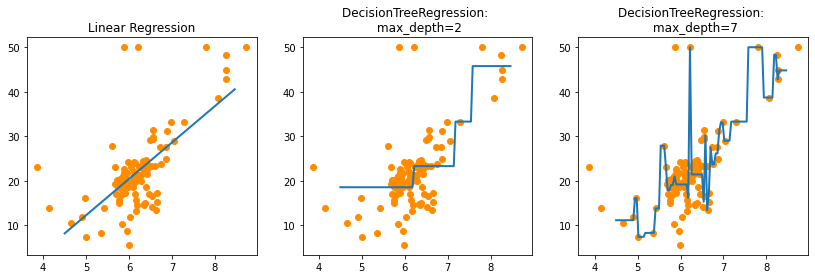

In [31]:
fig, (ax1, ax2, ax3)=plt.subplots(figsize=(14,4), ncols=3)

#X축 값을 4.5~8.5로 변환하여 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
#선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

#DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('DecisionTreeRegression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_rf2, label='max_depth:3', linewidth=2)

#DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('DecisionTreeRegression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax3.plot(X_test, pred_rf7, label='max_depth:7', linewidth=2)

회귀 트리와 선형의 다른 점이 확실히 보임. 회귀 트리는 분할되는 데이터 지점에 따라 브랜치 만들며 계단 형태로 회귀선을 만든다. max_depth=7인 경우 이상치까지 학습한 과적합이 되기 쉬운 모델이 됨.